In this part, we will work to implement a StyleGAN network. Traditional GANs
are black box models, in that it is hard to control the output of the
generator. The [paper](https://arxiv.org/abs/1812.04948) we study implements a new method of generating images
using a method they call "StyleGAN".

StyleGAN is an improvement on regular GAN by allowing the fine control of
different features of the image. This provides more control over how we want
our final output to look like.

## Preparing

In [ ]:
%%writefile model.py
from PIL import Image
from glob import glob
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import dotenv
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import warnings

dotenv.load_dotenv()
warnings.filterwarnings("ignore")

Overwriting model.py


In [ ]:
%run model.py
base_path = os.getenv("DATASET_BASE_PATH", "./data")
LOCAL_MODE_DEBUG = True
print("Running on local instance")

base_path = Path(base_path)
sample_dir = Path("./samples") # DO NOT CHANGE
out_dir = Path("./out")  # DO NOT CHANGE

print("Base path:", base_path)
print(os.listdir(base_path))
shutil.rmtree(sample_dir, ignore_errors=True)
os.makedirs(sample_dir, exist_ok=True)
shutil.rmtree(out_dir, ignore_errors=True)
os.makedirs(out_dir, exist_ok=True)

Mounted at /content/drive
Running on google colab
Base path: STYLEGAN
['.DS_Store', 'test', 'train']



Below we are just defining the basic dataset and dataloader code for the rest
of the network to function

In [ ]:
%%writefile -a model.py

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Appending to model.py


In [ ]:
%run model.py

print(device)

cuda


In [ ]:
IMAGE_SIZE = 512 if not LOCAL_MODE_DEBUG else 128
latent_size = 32 if not LOCAL_MODE_DEBUG else 8
num_epochs = 50 if not LOCAL_MODE_DEBUG else 5
batch_size = 64 if not LOCAL_MODE_DEBUG else 16

### Dataset

In [ ]:
%%writefile -a model.py

class ImageDataset(Dataset):
    def __init__(self, path, transform=None):
        self.images = glob(f"{path}/*.jpg")
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = self.images[idx % len(self.images)]
        image = Image.open(path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image

Appending to model.py


In [ ]:
%%writefile -a model.py

def get_transform(image_size):
    transform = T.Compose(
        [
            T.Resize(image_size),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    return transform

Appending to model.py


### The Generator for StyleGAN
Below is our atempt to implement the generator as described in the paper provided. There are x components the need to be implemented
- The fully connected 'mapping network' $f$. This consists of linear layers
- The AdaIN block, based off of eq 1 in the paper
- The 'Synthesis network' $g$. This consists of synthesis blocks
- The Synthesis block, consists of 2 conv layers and an 2 AdaIN blocks

#### The mapping network

In [ ]:
%%writefile -a model.py

class MappingNetwork(nn.Module):
    def __init__(self, latent, nlayers):
        super(MappingNetwork, self).__init__()
        layers = []
        for _ in range(nlayers):
            layers.append(nn.Linear(latent, latent))
            layers.append(nn.LeakyReLU(0.2))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x / x.norm(dim=1, keepdim=True)
        return self.layers(x)

Appending to model.py


#### The AdaIN block
Reference paper to further understand AdaIN ([Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization, Huang & Belongie, 2017](https://arxiv.org/pdf/1703.06868))

In [ ]:
%%writefile -a model.py

class AdaINBlock(nn.Module):
    def __init__(self, nc):
        super(AdaINBlock, self).__init__()
        self.norm = nn.InstanceNorm2d(nc)
        self.style_transform = nn.LazyLinear(nc * 2)

    def forward(self, x, style):
        style = self.style_transform(style)
        style = style.view(style.size(0), -1, 1, 1)
        ys, yb = style.chunk(2, dim=1)
        x = self.norm(x)
        return ys * x + yb

Appending to model.py


#### Synthesis Block

In [ ]:
%%writefile -a model.py

class SynthesisBlock(nn.Module):
    def __init__(self, nc):
        super(SynthesisBlock, self).__init__()
        self.noise1 = nn.Parameter(torch.randn(1, nc, 1, 1))
        self.conv1 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.adain1 = AdaINBlock(nc)

        self.noise2 = nn.Parameter(torch.randn(1, nc, 1, 1))
        self.conv2 = nn.Conv2d(nc, nc // 2, kernel_size=3, padding=1)
        self.adain2 = AdaINBlock(nc // 2)


    def forward(self, x, w, skip_conv1=False):
        noise1 = self.noise1 * torch.randn_like(x)
        x = x + noise1
        if not skip_conv1:
            x = self.conv1(x)
        x = self.adain1(x, w)

        noise2 = self.noise2 * torch.randn_like(x)
        x = x + noise2
        x = self.conv2(x)
        x = self.adain2(x, w)
        return x


Appending to model.py


#### Generator network

In [ ]:
%%writefile -a model.py

class GeneratorNetwork(nn.Module):
    def __init__(self, latent, image_size):
        super(GeneratorNetwork, self).__init__()
        self.n_synth = int(np.log2(image_size)) - 3
        self.mapping = MappingNetwork(latent, self.n_synth)
        synth_layers = []
        nc = image_size
        for i in range(self.n_synth):
            synth_layers.append(SynthesisBlock(nc))
            synth_layers.append(
                nn.Upsample(
                    scale_factor=2,
                    mode="bilinear",
                    align_corners=False,
                )
            )
            synth_layers.append(nn.LeakyReLU(0.2))
            nc //= 2
        self.constant = nn.Parameter(torch.randn(1, image_size, 8, 8))
        self.synthesis = nn.ModuleList(synth_layers)
        self.make_img = nn.Conv2d(nc, 3, kernel_size=3, padding=1)

    def forward(self, latent):
        latent = F.normalize(latent, p=2.0, dim=1)
        w = self.mapping(latent)
        x = self.constant.repeat(latent.size(0), 1, 1, 1)
        for i in range(0, 3 * self.n_synth, 3):
            x = self.synthesis[i](
                x, w, skip_conv1=True if i == 0 else False
            )  # SynthesisBlock
            # Based on paper, the first synthesis block directly uses the
            # const image, and does not use convolution
            x = self.synthesis[i + 1](x)  # Upsample
            x = self.synthesis[i + 2](x)  # activation
        return self.make_img(x)

Appending to model.py


### Discriminator

In [ ]:
%%writefile -a model.py

class DiscriminatorNetwork(nn.Module):
    def __init__(self, image_size):
        super(DiscriminatorNetwork, self).__init__()
        ncs = 16
        layers = [
            nn.Conv2d(3, ncs, kernel_size=3),
            nn.LeakyReLU(0.2),
        ]
        out = image_size - 3 + 1
        for i in range(5):
            layers.append(nn.Conv2d(ncs, ncs * 2, kernel_size=3, stride=2))
            layers.append(nn.LeakyReLU(0.2))
            if i > 0:
                layers.append(nn.Dropout(p=i/20))
            ncs = ncs * 2
            out = (out - 3 + 1) // 2
        layers.append(nn.Flatten())
        layers.append(nn.Dropout(p=0.4))
        layers.append(nn.Linear(ncs * out * out, 1))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

Appending to model.py


### Helper functions

In [ ]:
%%writefile -a model.py


# helper functions
def denorm(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    ndim = tensor.ndimension()

    if ndim == 4:
        mean = mean.unsqueeze(0)
        std = std.unsqueeze(0)

    denormalized_tensor = tensor * std + mean
    denormalized_tensor = denormalized_tensor.clamp(0, 1)

    if ndim == 3:
        denormalized_tensor = denormalized_tensor.permute(1, 2, 0)

    return denormalized_tensor


def save_fake_images(index, dir, G, sample_vectors, show=False):
    batch_size = sample_vectors.size(0)
    if batch_size > 16:
        sample_vectors = sample_vectors[:16]
    fake_images = G(sample_vectors)
    if index == -1:
        fake_fname = "fake_images_final.png"
    elif index == -2:
        fake_fname = "fake_images_generator_warmup.png"
    else:
        fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images.cpu()), os.path.join(dir, fake_fname), nrow=4)
    if show:
        img = Image.open(os.path.join(dir, fake_fname))
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis("off")
        plt.show()


def sample_image(G, latent_size, device):
    sample_vectors = torch.randn(1, latent_size).to(device)
    fake_images = G(sample_vectors)
    return (
        make_grid(denorm(fake_images.cpu()), nrow=1).permute(1, 2, 0).detach().numpy()
    )

Appending to model.py


In [ ]:
from model import GeneratorNetwork, DiscriminatorNetwork, ImageDataset
from model import get_transform, denorm, save_fake_images, sample_image

In [ ]:
train_data = ImageDataset(base_path / "train", transform=get_transform(IMAGE_SIZE))
train_loader = DataLoader(train_data, batch_size, shuffle=True)

In [ ]:
G = GeneratorNetwork(latent_size, IMAGE_SIZE)
G.to(device)

GeneratorNetwork(
  (mapping): MappingNetwork(
    (layers): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=32, out_features=32, bias=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Linear(in_features=32, out_features=32, bias=True)
      (9): LeakyReLU(negative_slope=0.2)
      (10): Linear(in_features=32, out_features=32, bias=True)
      (11): LeakyReLU(negative_slope=0.2)
    )
  )
  (synthesis): ModuleList(
    (0): SynthesisBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adain1): AdaINBlock(
        (norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (style_transform): LazyL

In [ ]:
D = DiscriminatorNetwork(IMAGE_SIZE)
D.to(device)

DiscriminatorNetwork(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Dropout(p=0.05, inplace=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (8): LeakyReLU(negative_slope=0.2)
    (9): Dropout(p=0.1, inplace=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (11): LeakyReLU(negative_slope=0.2)
    (12): Dropout(p=0.15, inplace=False)
    (13): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
    (14): LeakyReLU(negative_slope=0.2)
    (15): Dropout(p=0.2, inplace=False)
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Dropout(p=0.4, inplace=False)
    (18): Linear(in_features=100352, out_features=1, bias=True)
  )
)

## Training
Training on gpu

Saving fake_images-0000.png


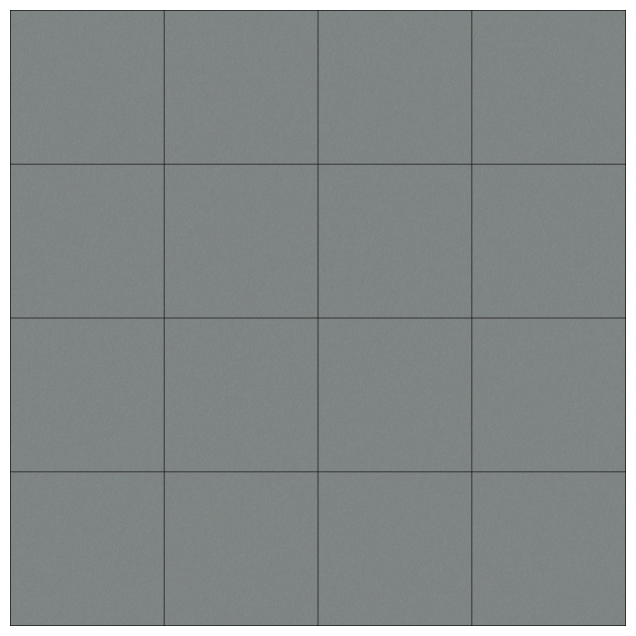

In [ ]:
# Before training
sample_vectors = torch.randn(batch_size, latent_size).to(device)
save_fake_images(0, sample_dir, G, sample_vectors, show=True)

In [ ]:
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003, betas=(0.5, 0.999))

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


def compute_gradient_penalty(D, real_samples, fake_samples):
    batch_size = real_samples.size(0)
    alpha = torch.rand(batch_size, 1, 1, 1, device=real_samples.device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    critic_interpolates = D(interpolates)
    gradients = torch.autograd.grad(
        outputs=critic_interpolates.sum(),
        inputs=interpolates,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty

def train_discriminator(images):
    batch_size = images.size(0)

    real_scores = D(images)

    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    fake_scores = D(fake_images)

    d_loss_real = -real_scores.mean()
    d_loss_fake = fake_scores.mean()
    d_loss = d_loss_real + d_loss_fake

    gradient_penalty = compute_gradient_penalty(D, images, fake_images)
    gp_lambda = 10.0
    d_loss = d_loss + gp_lambda * gradient_penalty

    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss, real_scores, fake_scores

def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    fake_scores = D(fake_images)

    g_loss = -fake_scores.mean()

    reset_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images


In [ ]:
total_step = len(train_loader)
peek = max([total_step // 5, 1])

d_losses_steps, g_losses_steps, real_scores_steps, fake_scores_steps = [], [], [], []
d_losses_epoch, g_losses_epoch, real_scores_epoch, fake_scores_epoch = [], [], [], []

best_d_loss, best_g_loss = np.inf, np.inf

for epoch in tqdm(range(num_epochs), desc="Training epochs", leave=True):
    d_loss_epoch, g_loss_epoch = 0, 0
    real_score_epoch, fake_score_epoch = 0, 0
    num_batches = 0

    for i, images in enumerate(train_loader):
        images = images.to(device)
        sample_vectors = torch.randn(batch_size, latent_size).to(device)

        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        d_losses_steps.append(d_loss.item())
        g_losses_steps.append(g_loss.item())
        real_scores_steps.append(real_score.mean().item())
        fake_scores_steps.append(fake_score.mean().item())

        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()
        real_score_epoch += real_score.mean().item()
        fake_score_epoch += fake_score.mean().item()
        num_batches += 1

        if (i + 1) % peek == 0 or LOCAL_MODE_DEBUG:
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch + 1,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )

    d_loss_epoch /= num_batches
    g_loss_epoch /= num_batches
    real_score_epoch /= num_batches
    fake_score_epoch /= num_batches

    d_losses_epoch.append(d_loss_epoch)
    g_losses_epoch.append(g_loss_epoch)
    real_scores_epoch.append(real_score_epoch)
    fake_scores_epoch.append(fake_score_epoch)

    print()
    print(
        "Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
            epoch + 1,
            num_epochs,
            d_loss_epoch,
            g_loss_epoch,
            real_score_epoch,
            fake_score_epoch,
        )
    )

    if epoch % 5 == 0 or LOCAL_MODE_DEBUG:
        save_fake_images(epoch + 1, sample_dir, G, sample_vectors, show=True)
    else:
        save_fake_images(epoch + 1, sample_dir, G, sample_vectors, show=False)

    print()

Output hidden; open in https://colab.research.google.com to view.

Saving fake_images_final.png


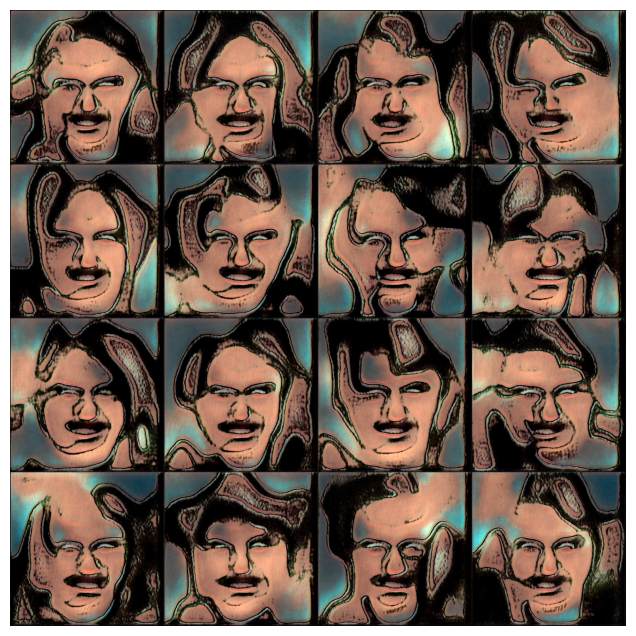

In [ ]:
save_fake_images(-1, sample_dir, G, sample_vectors, show=True)

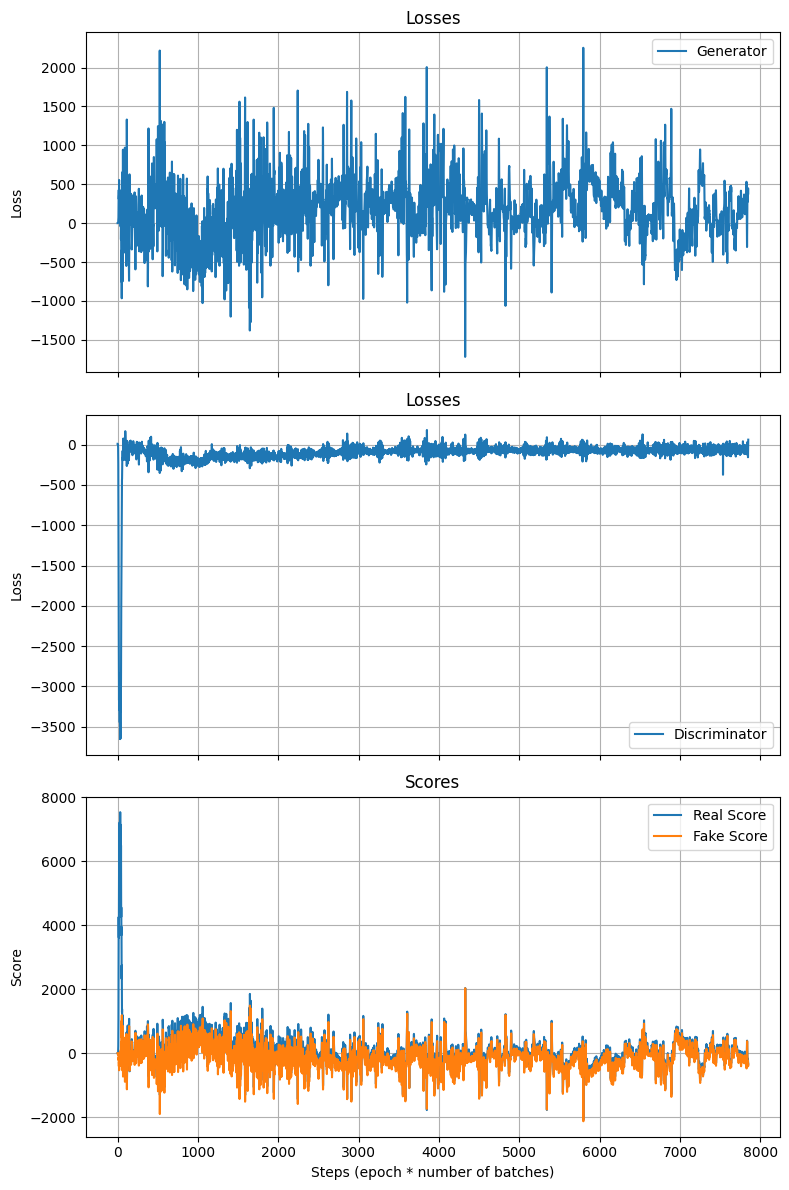

In [36]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

ax[0].plot(g_losses_steps, "-", label="Generator")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Losses")
ax[0].grid()

ax[1].plot(d_losses_steps, "-", label="Discriminator")
ax[1].set_ylabel("Loss")
ax[1].legend()
ax[1].set_title("Losses")
ax[1].grid()

ax[2].plot(real_scores_steps, "-", label="Real Score")
ax[2].plot(fake_scores_steps, "-", label="Fake Score")
ax[2].set_xlabel("Steps (epoch * number of batches)")
ax[2].set_ylabel("Score")
ax[2].legend()
ax[2].set_title("Scores")
ax[2].grid()

plt.tight_layout()
plt.show()

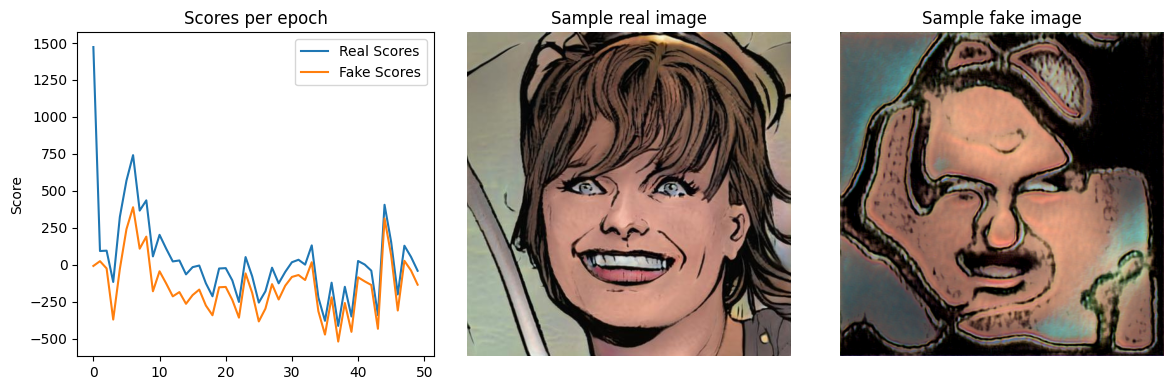

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()

ax[0].plot(real_scores_epoch, label="Real Scores")
ax[0].plot(fake_scores_epoch, label="Fake Scores")
ax[0].set_ylabel("Score")
ax[0].set_title("Scores per epoch")
ax[0].legend()

ax[1].imshow(denorm(next(iter(train_loader))[0]))
ax[1].set_title("Sample real image")
ax[1].axis("off")

ax[2].imshow(sample_image(G, latent_size, device))
ax[2].set_title("Sample fake image")
ax[2].axis("off")

plt.tight_layout()
plt.savefig(out_dir / "results.png")
plt.show()

Saving models on cpu for easy inference on any device

In [ ]:
D.to("cpu")
G.to("cpu")
torch.save(D.state_dict(), out_dir / "final_D.pth")
torch.save(G.state_dict(), out_dir / "final_G.pth")

## Inference

In [ ]:
with open("./inference.py", "w") as f:
    f.write(
        f"""from model import *


latent_size = {latent_size}
IMAGE_SIZE = {IMAGE_SIZE}
device = torch.device("cpu")
G = GeneratorNetwork(latent_size, IMAGE_SIZE)
G.load_state_dict(torch.load("./out/final_G.pth"))
plt.imshow(sample_image(G, latent_size, device))
plt.axis("off")
plt.show()
"""
    )


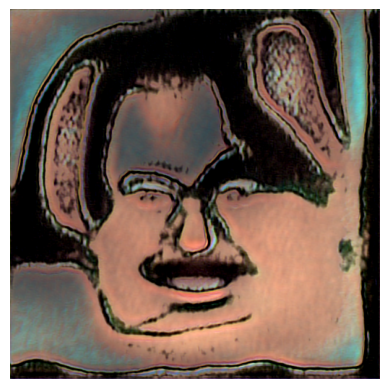

<Figure size 640x480 with 0 Axes>

In [35]:
%run ./inference.py

In [ ]:
with open("readme.txt", "w") as f:
    f.write(
        """model.py contains all the necassary class definitions and helper functions
inference.py contains minimal code to generate a single image from the best model
models and graphs found in ./out
sample images during training found in ./samples
"""
    )
!zip -r out.zip ./samples ./out model.py inference.py readme.txt

  adding: samples/ (stored 0%)
  adding: samples/fake_images-0012.png (deflated 0%)
  adding: samples/fake_images-0013.png (deflated 0%)
  adding: samples/fake_images-0011.png (deflated 0%)
  adding: samples/fake_images-0019.png (deflated 0%)
  adding: samples/fake_images-0043.png (deflated 0%)
  adding: samples/fake_images-0036.png (deflated 0%)
  adding: samples/fake_images-0009.png (deflated 0%)
  adding: samples/fake_images-0025.png (deflated 0%)
  adding: samples/fake_images-0020.png (deflated 0%)
  adding: samples/fake_images-0005.png (deflated 0%)
  adding: samples/fake_images-0022.png (deflated 0%)
  adding: samples/fake_images-0040.png (deflated 0%)
  adding: samples/fake_images-0044.png (deflated 0%)
  adding: samples/fake_images-0004.png (deflated 0%)
  adding: samples/fake_images-0048.png (deflated 0%)
  adding: samples/fake_images-0049.png (deflated 0%)
  adding: samples/fake_images-0038.png (deflated 0%)
  adding: samples/fake_images-0042.png (deflated 0%)
  adding: sampl